# Evaluations for Text Extraction and Report Generation

### 1. Libraries

In [149]:
import pandas as pd
from tabulate import tabulate
import os
from lxml import html
from zss import simple_distance
import editdistance
import shutil
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Spacer

### 2. Helper Functions

In [152]:
def convert_csv_to_html(csv_file, output_html_file):
    df = pd.read_csv(csv_file)
    html_table = tabulate(df, tablefmt='html', headers='keys', showindex=False)
    
    with open(output_html_file, 'w') as html_file:
        html_file.write(html_table)

def convert_csv_list_to_html(csv_file_list, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for csv_file in csv_file_list:
        
        base_filename = os.path.splitext(os.path.basename(csv_file))[0]
        output_html_file = os.path.join(output_folder, f"{base_filename}.html")
        
        convert_csv_to_html(csv_file, output_html_file)
        print(f"Converted {csv_file} to {output_html_file}")

### Specify Folder Name Based on Method 
* 2.1 =  Using Morphological Operations Tesseract
* 2.2 =  PaddleOCR
* 2.3 = Paddle OCR and Bounding Boxes from cv2: 


###  Change `folder_name` constant according to method used.

In [6]:

folder_name = '2.1 CSV Outputs'

def extract_csv_files(input_directory, output_directory):
    # Create the 'CSV Outputs' directory if it doesn't exist
    csv_output_directory = os.path.join(output_directory,folder_name)
    os.makedirs(csv_output_directory, exist_ok=True)

    for root, dirs, files in os.walk(input_directory):
        for dir_name in dirs:
            if dir_name.endswith("Cropped Images"):
                current_dir = os.path.join(root, dir_name)
                # List CSV files in the current directory with the naming pattern
                csv_files = [f for f in os.listdir(current_dir) if f.endswith('_table_0.csv') or f.endswith('_table_1.csv') ]
                for csv_file in csv_files:
                    source_path = os.path.join(current_dir, csv_file)
                    destination_path = os.path.join(csv_output_directory, csv_file)
                    shutil.copy2(source_path, destination_path)
                    print(f"Extracted {csv_file} to {folder_name}")

# Example usage
input_directory = 'WAMEX_DATA_EXTRACTED'
output_directory = ''  

extract_csv_files(input_directory, output_directory)

Extracted 112461_7_table_0.csv to 2.1 CSV Outputs
Extracted 112540_7_table_0.csv to 2.1 CSV Outputs
Extracted 112540_7_table_1.csv to 2.1 CSV Outputs
Extracted 112540_8_table_0.csv to 2.1 CSV Outputs
Extracted 112697_12_table_0.csv to 2.1 CSV Outputs
Extracted 112697_18_table_0.csv to 2.1 CSV Outputs
Extracted 112697_19_table_0.csv to 2.1 CSV Outputs
Extracted 112697_21_table_0.csv to 2.1 CSV Outputs
Extracted 112697_4_table_0.csv to 2.1 CSV Outputs
Extracted 112697_8_table_0.csv to 2.1 CSV Outputs
Extracted 112697_8_table_1.csv to 2.1 CSV Outputs
Extracted 112761_15_table_0.csv to 2.1 CSV Outputs
Extracted 112761_17_table_0.csv to 2.1 CSV Outputs
Extracted 112761_7_table_0.csv to 2.1 CSV Outputs
Extracted 114158_14_table_0.csv to 2.1 CSV Outputs
Extracted 114158_14_table_1.csv to 2.1 CSV Outputs
Extracted 114158_16_table_0.csv to 2.1 CSV Outputs
Extracted 114158_18_table_0.csv to 2.1 CSV Outputs
Extracted 114158_2_table_0.csv to 2.1 CSV Outputs
Extracted 114158_3_table_0.csv to 2.1 CS

### Calculating TED Similarity with Original Annotations and Generated Extractions

In [126]:
# Function to calculate TEDS similarity
def calculate_teds_similarity(csv_file1, csv_file2):
    try:
        df1 = pd.read_csv(csv_file1)
        df2 = pd.read_csv(csv_file2)

        csv_str1 = df1.to_csv(index=False)
        csv_str2 = df2.to_csv(index=False)

        teds_similarity = 1 - editdistance.eval(csv_str1, csv_str2) / max(len(csv_str1), len(csv_str2))
    except pd.errors.EmptyDataError:
        # Handle EmptyDataError (empty CSV files)
        teds_similarity = 0  

    return teds_similarity


def match_and_calculate_teds(input_directory, sample_tables_directory, output_folder_name):
    csv_output_directory = os.path.join(output_directory, output_folder_name)
    os.makedirs(csv_output_directory, exist_ok=True)

    teds_scores = []  
    csv_pairs = []  

    for csv_file in os.listdir(csv_output_directory):
        matching_csv_file_0 = csv_file.replace('_table_0.csv', '_ans_0.csv')
        matching_csv_file_1 = csv_file.replace('_table_1.csv', '_ans_1.csv')

        matching_csv_path_0 = os.path.join(sample_tables_directory, matching_csv_file_0)
        matching_csv_path_1 = os.path.join(sample_tables_directory, matching_csv_file_1)

        if os.path.exists(matching_csv_path_0) or os.path.exists(matching_csv_path_1):
            teds_similarity = None

            if os.path.exists(matching_csv_path_0) and os.path.exists(matching_csv_path_1):
                # Both variations exist, calculate the similarity for the one with the highest score
                teds_similarity_0 = calculate_teds_similarity(os.path.join(csv_output_directory, csv_file), matching_csv_path_0)
                teds_similarity_1 = calculate_teds_similarity(os.path.join(csv_output_directory, csv_file), matching_csv_path_1)

                if teds_similarity_0 > teds_similarity_1:
                    teds_similarity = teds_similarity_0
                    matching_csv_file = matching_csv_file_0
                else:
                    teds_similarity = teds_similarity_1
                    matching_csv_file = matching_csv_file_1
            elif os.path.exists(matching_csv_path_0):
                teds_similarity = calculate_teds_similarity(os.path.join(csv_output_directory, csv_file), matching_csv_path_0)
                matching_csv_file = matching_csv_file_0
            else:
                teds_similarity = calculate_teds_similarity(os.path.join(csv_output_directory, csv_file), matching_csv_path_1)
                matching_csv_file = matching_csv_file_1

            teds_scores.append(teds_similarity)
            csv_pairs.append((csv_file, matching_csv_file))

            print(f"TEDS Similarity between {csv_file} and {matching_csv_file}: {teds_similarity:.4f}")

    teds_scores_df = pd.DataFrame({'CSV Pair': csv_pairs, 'TEDS Score': teds_scores})

    average_teds_score = sum(teds_scores) / len(teds_scores) if teds_scores else 0
    print(f"Average TEDS Similarity: {average_teds_score:.4f}")
    return teds_scores_df

input_directory = 'WAMEX_DATA_EXTRACTED'
sample_tables_directory = 'Capstone Project - Table Text Extraction/Sample Tables Original'
output_directory = '.'  


teds_scores_df_21 = match_and_calculate_teds(input_directory, sample_tables_directory, '2.1 CSV Outputs')
teds_scores_df_22 = match_and_calculate_teds(input_directory, sample_tables_directory, '2.2 CSV Outputs')
teds_scores_df_23 = match_and_calculate_teds(input_directory, sample_tables_directory, '2.3 CSV Outputs')


TEDS Similarity between 112461_7_table_0.csv and 112461_7_ans_0.csv: 0.9074
TEDS Similarity between 112540_7_table_0.csv and 112540_7_ans_0.csv: 0.2857
TEDS Similarity between 112540_7_table_1.csv and 112540_7_ans_1.csv: 0.9235
TEDS Similarity between 112540_8_table_0.csv and 112540_8_ans_0.csv: 0.8280
TEDS Similarity between 112761_17_table_0.csv and 112761_17_ans_0.csv: 0.9055
TEDS Similarity between 112761_7_table_0.csv and 112761_7_ans_0.csv: 0.9181
TEDS Similarity between 132302_10_table_0.csv and 132302_10_ans_0.csv: 0.9226
TEDS Similarity between 132302_21_table_0.csv and 132302_21_ans_0.csv: 0.8862
TEDS Similarity between 132302_22_table_0.csv and 132302_22_ans_0.csv: 0.8902
TEDS Similarity between 132302_22_table_1.csv and 132302_22_ans_1.csv: 0.8731
TEDS Similarity between 132302_27_table_0.csv and 132302_27_ans_0.csv: 0.2754
TEDS Similarity between 132302_28_table_0.csv and 132302_28_ans_0.csv: 0.7621
TEDS Similarity between 132302_28_table_1.csv and 132302_28_ans_1.csv: 0.1

### Visualization Setup

In [127]:
teds_scores_df_21.columns.values[1] = "Morphological Operations Tesseract TEDS"
teds_scores_df_22.columns.values[1] = "PaddleOCR Avg TEDS"
teds_scores_df_23.columns.values[1] = "Paddle + CV2 Avg TEDS"

numeric_range1 = range(1, len(teds_scores_df_21) + 1)
numeric_range2 = range(1, len(teds_scores_df_22) + 1)
numeric_range3 = range(1, len(teds_scores_df_23) + 1)

teds_scores_df_21['CSV Pair'] = numeric_range1
teds_scores_df_22['CSV Pair'] = numeric_range2
teds_scores_df_23['CSV Pair'] = numeric_range3


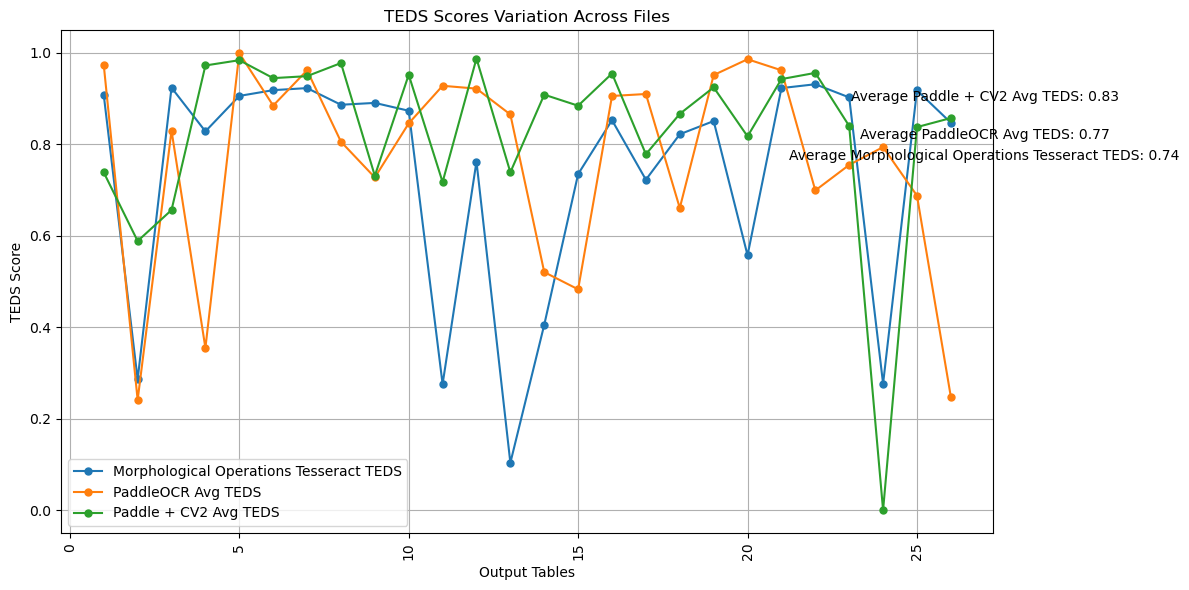

In [128]:
# Combine the three dataframes without duplicating "CSV Pair" column
combined_df = pd.concat([teds_scores_df_21.set_index('CSV Pair'), 
                         teds_scores_df_22.set_index('CSV Pair'), 
                         teds_scores_df_23.set_index('CSV Pair')], axis=1)

numeric_range = range(1, len(combined_df) + 1)

fig, ax = plt.subplots(figsize=(12, 6))
for col_name in combined_df.columns:
    teds_scores = combined_df[col_name]
    ax.plot(numeric_range, teds_scores, marker='o', linestyle='-', markersize=5, label=col_name)

ax.set_xlabel('Output Tables')
ax.set_ylabel('TEDS Score')
ax.set_title('TEDS Scores Variation Across Files')
ax.grid(True)
average_scores = [sum(combined_df[col_name]) / len(combined_df) for col_name in combined_df.columns]
plt.xticks(rotation=90)
ax.legend()

for i, (avg_score, col_name) in enumerate(zip(average_scores, combined_df.columns)):
    x_position = numeric_range[-1] + 1  # Adjust x-coordinate to the right of the last data point
    y_position = avg_score + 0.02 * (i + 1)  # Adjust this value for vertical separation
    ax.text(x_position, y_position, f'Average {col_name}: {avg_score:.2f}', ha='center', va='bottom', color='black')

# Show the plot
plt.tight_layout()
plt.show()


### Report Generation for all 3 Methods

In [143]:
def create_pdf_report(input_folder, output_pdf, report_name):
    csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

    if not csv_files:
        print("No CSV files found in the input folder.")
        return

    table_data = []

    for csv_file in csv_files:
        csv_path = os.path.join(input_folder, csv_file)
        try:
            df = pd.read_csv(csv_path)
        except pd.errors.EmptyDataError:
            print(f"Skipping empty CSV file: {csv_file}")
            continue

        if not df.empty:
            table_data.append(df.values.tolist())
        else:
            print(f"Skipping empty CSV file: {csv_file}")

    if not table_data:
        print("No valid data found in the CSV files.")
        return

    doc = SimpleDocTemplate(output_pdf, pagesize=letter)
    elements = []

    for data in table_data:
        table = Table(data)

        style = TableStyle([
            ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
            ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
            ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
            ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
            ('GRID', (0, 0), (-1, -1), 1, colors.black),
            ('SPACEAFTER', (0, 0), (-1, -1), 10)  # Add space after each table
        ])
        table.setStyle(style)

        elements.append(table)

        elements.append(Spacer(1, 0.2 * 72))  # 0.2 inch spacing

    doc.build(elements)

    print(f"PDF report '{report_name}' created successfully at '{output_pdf}'.")


In [144]:
input_folder = '2.1 CSV Outputs'
output_pdf = 'Tesseract.pdf'
report_name = 'Tables Extraction Report'

create_pdf_report(input_folder, output_pdf, report_name)

Skipping empty CSV file: 132241_16_table_0.csv
Skipping empty CSV file: 132241_18_table_0.csv
Skipping empty CSV file: 132241_19_table_0.csv
Skipping empty CSV file: 132302_19_table_0.csv
Skipping empty CSV file: 132302_26_table_0.csv
Skipping empty CSV file: 132302_30_table_0.csv
Skipping empty CSV file: 132302_9_table_0.csv
PDF report 'Tables Extraction Report' created successfully at 'Tesseract.pdf'.


In [146]:
input_folder = '2.2 CSV Outputs'
output_pdf = 'PaddleOCR.pdf'
report_name = 'Tables Extraction Report'

create_pdf_report(input_folder, output_pdf, report_name)

Skipping empty CSV file: 132241_16_table_0.csv
Skipping empty CSV file: 132241_18_table_0.csv
Skipping empty CSV file: 132241_19_table_0.csv
Skipping empty CSV file: 132302_19_table_0.csv
Skipping empty CSV file: 132302_26_table_0.csv
Skipping empty CSV file: 132302_30_table_0.csv
Skipping empty CSV file: 132302_9_table_0.csv
PDF report 'Tables Extraction Report' created successfully at 'PaddleOCR.pdf'.


In [145]:
input_folder = '2.3 CSV Outputs'
output_pdf = 'PaddleOCR with Bounding Boxes cv2.pdf'
report_name = 'Tables Extraction Report'

create_pdf_report(input_folder, output_pdf, report_name)

Skipping empty CSV file: 114158_14_table_0.csv
Skipping empty CSV file: 114158_2_table_0.csv
Skipping empty CSV file: 114158_3_table_0.csv
Skipping empty CSV file: 129866_17_table_0.csv
Skipping empty CSV file: 132241_16_table_0.csv
Skipping empty CSV file: 132241_18_table_0.csv
Skipping empty CSV file: 132241_19_table_0.csv
Skipping empty CSV file: 132241_21_table_0.csv
Skipping empty CSV file: 132302_19_table_0.csv
Skipping empty CSV file: 132302_26_table_0.csv
Skipping empty CSV file: 132302_30_table_0.csv
Skipping empty CSV file: 132302_9_table_0.csv
Skipping empty CSV file: 134934_13_table_0.csv
PDF report 'Tables Extraction Report' created successfully at 'PaddleOCR with Bounding Boxes cv2.pdf'.
